In [76]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier

In [3]:
data = pd.read_csv("../data/raw/Chapter_3_Diabetes_data.csv", low_memory=False)
data.shape

(101768, 50)

In [4]:
data.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98571
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40257
medical_specialty           49951
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [5]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Some numbers in data are actually categories, let's convert them

In [6]:
categorical = [
    "encounter_id",
    "patient_nbr",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id"
]
for variable in categorical:
    data[variable] = pd.Categorical(data[variable])

In [7]:
data.describe(include=["category"])

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id
count,101768,101768,101768,101768,101768
unique,101766,71518,8,26,17
top,443867222,88785891,1,1,7
freq,2,40,53992,60236,57496


In [8]:
data.shape[0], data["encounter_id"].nunique(), data["patient_nbr"].nunique()

(101768, 101766, 71518)

#### Looks like there are 2 potential duplicated rows, let's remove them

In [9]:
data.drop_duplicates(inplace=True)

#### Seems like patients are repeating in a dataset. Let's see how data looks for repeating patients

In [10]:
rows_per_patient = data.groupby('patient_nbr')["encounter_id"].count()

In [11]:
data = data.merge(rows_per_patient, on='patient_nbr', suffixes=("", "_count"))

In [17]:
data["running_count"] = data.groupby("patient_nbr").cumcount()

In [12]:
data[data["encounter_id_count"] > 1].head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,encounter_id_count
12,40926,85504905,Caucasian,Female,[40-50),NaN,1,3,7,7,NaN,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30,2
13,76387002,85504905,Caucasian,Female,[40-50),NaN,1,6,7,9,NaN,InfectiousDiseases,46,1,14,0,0,0,730,250.81,707,9,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,2
28,248916,115196778,Caucasian,Female,[50-60),NaN,1,1,1,2,NaN,Surgery-General,25,2,11,0,0,0,996,585,250.01,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,5
29,6068238,115196778,Caucasian,Female,[50-60),NaN,1,3,7,5,NaN,Family/GeneralPractice,44,1,16,0,0,3,427,585,250.41,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,5
30,33695262,115196778,Caucasian,Female,[60-70),NaN,1,1,7,7,NaN,Surgery-General,45,4,21,0,0,15,996,38,403,8,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30,5
31,45573132,115196778,Caucasian,Female,[60-70),NaN,1,1,7,2,NaN,Surgery-General,31,2,13,0,0,14,996,403,413,7,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,5
32,77757156,115196778,Caucasian,Female,[60-70),NaN,1,1,7,7,NaN,Pulmonology,47,1,20,0,0,2,493,403,786,6,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,5
33,250872,41606064,Caucasian,Male,[20-30),NaN,2,1,2,10,NaN,NaN,53,0,20,0,0,0,277,250.02,263,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,3
34,2309376,41606064,Caucasian,Male,[20-30),NaN,2,1,2,2,NaN,NaN,35,0,12,0,0,1,277,250.02,753,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,3
35,11198010,41606064,Caucasian,Male,[20-30),NaN,2,1,2,9,NaN,NaN,36,0,18,1,0,3,277,250.02,753,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,3


In [13]:
def plot_bar(column: str) -> None:
    data[column].value_counts().plot.bar(title=column)

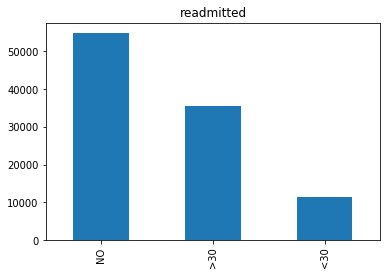

In [14]:
plot_bar("readmitted")

In [15]:
data["target"] = data["readmitted"] != "NO"

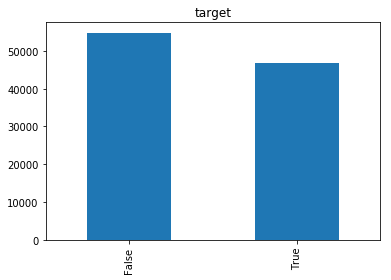

In [16]:
plot_bar("target")

In [18]:
data.set_index("encounter_id", inplace=True)

In [19]:
not_train_columns = [
           "patient_nbr", 
           "payer_code", 
           "medical_specialty",
           "weight",
           "diag_1",
           "diag_2",
           "diag_3",
           "change",
           "diabetesMed",
           "readmitted",
           "running_count",
           "encounter_id_count",
           "target"]

In [20]:
data["race"] = data["race"].fillna("NA")
data["medical_specialty"] = data["medical_specialty"].fillna("NA")

In [21]:
data = data.sort_values(by="encounter_id")

In [99]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(not_train_columns, axis=1),
    data["target"],
    shuffle=False,
    test_size=0.30)

In [100]:
cat = [t != "int64" for t in x_train.dtypes]
num = [t == "int64" for t in x_train.dtypes]

transformer = ColumnTransformer(
    [("cat",  OneHotEncoder(handle_unknown="ignore"), cat),
     ("num", Normalizer(), num)]
)

x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)

In [101]:
clf = LogisticRegression(random_state=42, solver="liblinear")
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [116]:
accuracy_score(y_train.to_list(), clf.predict(x_train))

0.6258773653770565

In [112]:
accuracy_score(y_test.to_list(), clf.predict(x_test))
# roc_auc_score(y_test.to_list(), clf.predict_proba(x_test)[:, 1])

0.6186046511627907

In [104]:
clf2 = RandomForestClassifier()

In [105]:
clf2.fit(x_train, y_train)

C:\Users\artem.tuisuzov\Continuum\anaconda3\envs\datascience\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [114]:
accuracy_score(y_test.to_list(), clf2.predict(x_test))
# roc_auc_score(y_test.to_list(), clf2.predict_proba(x_test)[:, 1])

0.5929249918113331

In [107]:
model = CatBoostClassifier(iterations=20)

In [108]:
y_train_int = [int(x) for x in y_train.to_list()]

In [109]:
y_test_int = [int(x) for x in y_test.to_list()]

In [110]:
model.fit(x_train.toarray(), y_train_int)

Learning rate set to 0.5
0:	learn: 0.6591015	total: 153ms	remaining: 2.91s
1:	learn: 0.6499307	total: 257ms	remaining: 2.31s
2:	learn: 0.6446894	total: 383ms	remaining: 2.17s
3:	learn: 0.6409537	total: 461ms	remaining: 1.84s
4:	learn: 0.6385281	total: 557ms	remaining: 1.67s
5:	learn: 0.6368151	total: 655ms	remaining: 1.53s
6:	learn: 0.6342618	total: 737ms	remaining: 1.37s
7:	learn: 0.6330340	total: 824ms	remaining: 1.24s
8:	learn: 0.6321050	total: 931ms	remaining: 1.14s
9:	learn: 0.6314698	total: 1s	remaining: 1s
10:	learn: 0.6301177	total: 1.1s	remaining: 901ms
11:	learn: 0.6294801	total: 1.19s	remaining: 796ms
12:	learn: 0.6287905	total: 1.27s	remaining: 684ms
13:	learn: 0.6280339	total: 1.37s	remaining: 587ms
14:	learn: 0.6265683	total: 1.48s	remaining: 494ms
15:	learn: 0.6262090	total: 1.56s	remaining: 389ms
16:	learn: 0.6256361	total: 1.65s	remaining: 292ms
17:	learn: 0.6251452	total: 1.75s	remaining: 194ms
18:	learn: 0.6247848	total: 1.84s	remaining: 96.7ms
19:	learn: 0.6243370	t

In [117]:
accuracy_score(y_test_int, model.predict(x_test.toarray()))
# roc_auc_score(y_test.to_list(), model.predict_proba(x_test.toarray())[:, 1])

0.626826072715362